In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

import IPython.display as ipd
#import os
#model_dir = "/".join(os.getcwd().split("/")[:-1] + ['models/'])
model_dir = "./models/"
import models
from utils import test_accuracy, train_epoch, show_weights, model_prune, print_dims, get_weight_penalty, prune_plot
import copy
from tensorboardX import SummaryWriter
writer = SummaryWriter('tensorboard/run1/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")


#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()
use_cuda = torch.cuda.is_available()

#arguments
model_name = 'LeNet_300_100'
training_epochs=20
retraining_epochs=50
temp_list = [1, 5, 10, 15, 20, 25, 30]

## LeNet 300-100

### 1. Train Model

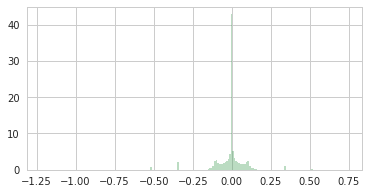

In [252]:
def show_all_weights(model):
    weights = np.array([], dtype=np.float32)
    for layer in model.state_dict():
        weights = np.hstack( (weights, model.state_dict()[layer].view(-1).cpu().numpy()) )
    plt.clf()
    plt.figure(figsize=(6, 3))
    sns.distplot(weights, kde=False, color="g",bins=200,norm_hist=True)
    plt.show()
    
show_all_weights(model)

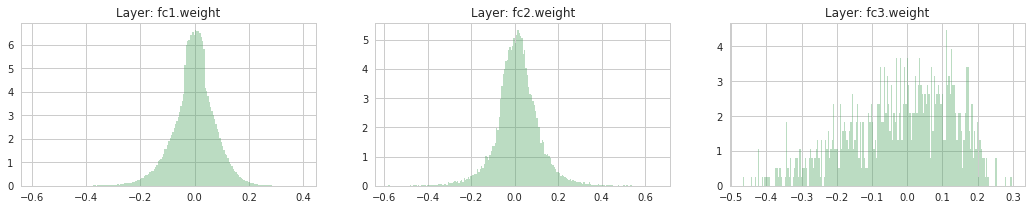

In [178]:
def show_weights(model):
    weight_list = [x for x in model.state_dict().keys() if 'weight' in x]
    plt.clf()
    plt.figure(figsize=(18, 3))
    for i,weight in enumerate(weight_list):
        plt.subplot(131 + i)
        fc_w = model.state_dict()[weight]
        sns.distplot(fc_w.view(-1).cpu().numpy(), kde=False, color="g",bins=200,norm_hist=True)
        plt.title('Layer: {}'.format(weight))
    plt.show()
    
show_weights(model)

In [257]:
def logsumexp(t, w=1, axis=1):
    #print (t.shape)
    t_max, _ = t.max(dim=1)
    if (axis==1):
        t = t-t_max.repeat(t.size(1), 1).t()
    else:
        t = t-t_max.repeat(1, t.size(0)).t()
    t = w * t.exp()
    t = t.sum(dim=axis)
    t.log_()
    return t + t_max

class GaussianMixturePrior(Module):
    def __init__(self, nb_components, network_weights, pi_zero, **kwargs):
        super(GaussianMixturePrior, self).__init__()
        
        self.nb_components = nb_components 
        self.network_weights = [p.view(-1) for p in network_weights]
        self.pi_zero = pi_zero
        
        #Build
        J = self.nb_components
        pi_zero = self.pi_zero
        
        #    ... means
        init_means = torch.linspace(-0.6, 0.6, J - 1)
        self.means = Variable(init_means.cuda(), requires_grad=True)
        
        #precision
        init_stds = torch.FloatTensor(np.tile(0.05, J) )
        self.gammas = Variable( (- torch.log(torch.pow(init_stds, 2))).cuda(), requires_grad=True)
        
        #mixing proportions
        init_mixing_proportions = torch.ones((J - 1))
        init_mixing_proportions *= (1. - pi_zero) / (J - 1)
        self.rhos = Variable((init_mixing_proportions).cuda(), requires_grad=True)
        
        #self.loss = Variable(torch.cuda.FloatTensor([0.]), requires_grad=True)
        
    def call(self, mask=None):
        J=self.nb_components
        loss = Variable(torch.cuda.FloatTensor([0.]), requires_grad=True)
        means = torch.cat(( Variable(torch.cuda.FloatTensor([0.]), requires_grad=True) , self.means), 0)
        #mean=self.means
        precision = self.gammas.exp()
        
        min_rho = self.rhos.min()
        mixing_proportions = (self.rhos - min_rho).exp()
        mixing_proportions = (1 - self.pi_zero) * mixing_proportions/mixing_proportions.sum()
        mixing_proportions = torch.pow(mixing_proportions, 2)
        mixing_proportions = torch.cat(( Variable(torch.cuda.FloatTensor([self.pi_zero])) , mixing_proportions), 0)
        
        for weights in self.network_weights:
            loss = loss + self.compute_loss(weights, mixing_proportions, means, precision)
        
        
        # GAMMA PRIOR ON PRECISION
        # ... for the zero component
        
        #Replacing gather with indexing -- same calculation?
        (alpha, beta) = (5e3,20e-1)
        #print (torch.gather(self.gammas, 0, Variable(torch.cuda.LongTensor([0,1,2]))))
        neglogprop = (1 - alpha) * self.gammas[0] + beta * precision[0]
        loss = loss + neglogprop.sum()
        # ... and all other component
        alpha, beta = (2.5e2,1e-1)
        neglogprop = (1 - alpha) * self.gammas[1:J] + beta * precision[1:J]
        loss = loss + neglogprop.sum()
        return loss
        
        
    def compute_loss(self, weights, mixing_proportions, means, precision):
        diff = weights.expand(means.size(0), -1) - means.expand(weights.size(0), -1).t()
        unnormalized_log_likelihood = (-(diff ** 2)/2).t() * precision
        #unnormalized_log_likelihood = (-1/2) * precision.matmul((diff ** 2))
        Z = precision.sqrt() / (2 * np.pi)
        #global myt
        #myt=unnormalized_log_likelihood
        log_likelihood = logsumexp(unnormalized_log_likelihood, w=(mixing_proportions * Z), axis=1)
        return -log_likelihood.sum()

In [266]:
def train_epoch_sws(model, optimizer, optimizer_gmp, optimizer_gmp2, criterion, train_loader):
    """
    train model
    
    model: neural network model
    optimizer: optimization algorithm/configuration
    criterion: loss function
    train_loader: training dataset dataloader
    """
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        #if(use_cuda):
        images=images.cuda()
        labels=labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        optimizer_gmp.zero_grad()
        optimizer_gmp2.zero_grad()
        # Forward pass to get output/logits
        outputs = model(images)
        # Calculate Loss: softmax --> cross entropy loss
        #loss = criterion(outputs, labels) + 0.001 * ( (model.fc1.weight - 0.05).norm() + (model.fc2.weight - 0.05).norm() + (model.fc3.weight - 0.05).norm() + (model.fc1.weight + 0.05).norm() + (model.fc2.weight + 0.05).norm() + (model.fc3.weight + 0.05).norm())
        loss = criterion(outputs, labels) + 1e-4 * -gmp.call()
        #print (criterion(outputs, labels))
        #print (gmp.call())
        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
        optimizer.step()
        optimizer_gmp.step()
        optimizer_gmp2.step()
    return model, criterion(outputs, labels)

**Default Training**

Epoch: 2. Loss: 1.471575379371643. Accuracy: 97.4
Means: [-0.594, -0.519, -0.434, -0.35, -0.256, -0.164, -0.076, 0.0, 0.075, 0.164, 0.258, 0.349, 0.434, 0.52, 0.606]
Mixing Proportions: [2.341, 2.479, 0.342, -1.611, -2.143, -1.948, 1.969, 2.125, 1.962, -1.866, -2.227, -1.436, 2.551, 2.214, 2.161]
Precisions: [7.762, 7.52, 7.846, 8.022, 6.911, 3.827, 7.811, 8.437, 7.208, 8.411, 7.958, 3.777, 7.262, 7.856, 6.492, 5.764]


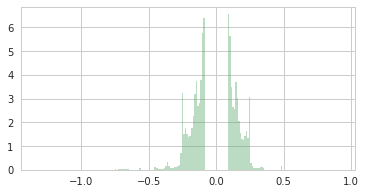

Epoch: 4. Loss: 1.4819012880325317. Accuracy: 97.47
Means: [-0.594, -0.524, -0.437, -0.348, -0.265, -0.168, -0.071, 0.0, 0.071, 0.168, 0.267, 0.353, 0.432, 0.528, 0.596]
Mixing Proportions: [4.75, 4.87, 3.372, -2.284, -4.986, -3.167, 4.135, 4.434, 4.069, -2.998, -5.061, -1.963, 4.955, 4.57, 4.491]
Precisions: [8.443, 8.342, 10.117, 10.929, 8.581, 1.08, 9.855, 9.685, 8.264, 9.67, 9.892, 1.372, 8.406, 8.509, 8.526, 8.375]


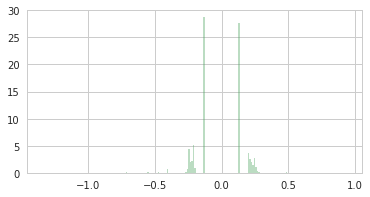

Epoch: 6. Loss: 1.4611506462097168. Accuracy: 97.6
Means: [-0.6, -0.519, -0.437, -0.347, -0.266, -0.169, -0.071, 0.0, 0.071, 0.169, 0.268, 0.354, 0.428, 0.533, 0.596]
Mixing Proportions: [6.413, 6.519, 5.688, -2.308, -6.846, -3.191, 6.152, 6.007, 6.071, -3.022, -6.94, -1.974, 6.603, 6.202, 6.091]
Precisions: [8.616, 9.781, 13.228, 14.492, 8.966, -1.354, 10.319, 9.906, 8.742, 9.895, 10.361, -1.166, 8.809, 10.528, 12.327, 9.969]


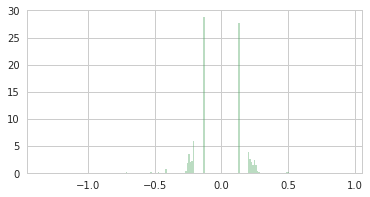

Epoch: 8. Loss: 1.4746216535568237. Accuracy: 97.78
Means: [-0.6, -0.519, -0.437, -0.347, -0.266, -0.169, -0.071, 0.0, 0.071, 0.169, 0.269, 0.354, 0.428, 0.533, 0.596]
Mixing Proportions: [7.798, 7.873, 8.295, -2.308, -8.46, -3.196, 8.208, 7.231, 8.098, -3.026, -8.547, -1.97, 7.96, 7.531, 7.361]
Precisions: [8.745, 11.619, 18.823, 20.132, 9.242, -3.18, 10.725, 10.102, 11.193, 10.086, 10.78, -3.033, 9.294, 14.778, 17.876, 15.323]


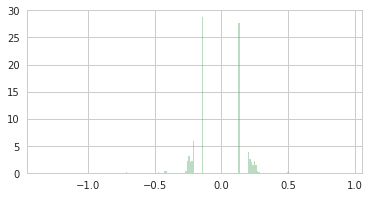

Epoch: 10. Loss: 1.461679458618164. Accuracy: 97.84
Means: [-0.6, -0.519, -0.437, -0.347, -0.266, -0.169, -0.071, 0.0, 0.071, 0.169, 0.269, 0.354, 0.428, 0.533, 0.596]
Mixing Proportions: [8.66, 8.696, 11.39, -2.307, -9.977, -3.196, 10.243, 7.906, 10.074, -3.026, -10.061, -1.969, 8.787, 8.325, 8.086]
Precisions: [8.859, 17.271, 24.914, 26.223, 9.788, -4.798, 11.403, 10.373, 17.193, 10.341, 11.537, -4.668, 11.014, 20.862, 23.966, 21.415]


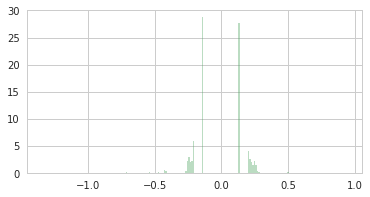

Epoch: 12. Loss: 1.461167335510254. Accuracy: 97.78
Means: [-0.6, -0.519, -0.437, -0.347, -0.266, -0.169, -0.071, 0.0, 0.071, 0.169, 0.269, 0.354, 0.428, 0.533, 0.596]
Mixing Proportions: [8.894, 8.913, 14.167, -2.307, -11.449, -3.196, 11.421, 8.069, 11.177, -3.026, -11.53, -1.968, 9.007, 8.531, 8.266]
Precisions: [8.971, 23.62, 31.263, 32.573, 11.755, -6.322, 13.916, 10.89, 23.543, 10.815, 14.56, -6.202, 16.832, 27.211, 30.316, 27.764]


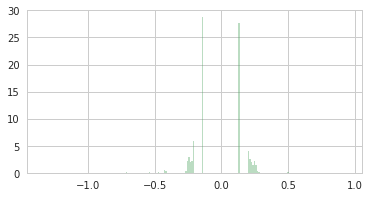

Epoch: 14. Loss: 1.471567153930664. Accuracy: 97.78
Means: [-0.6, -0.519, -0.437, -0.347, -0.266, -0.169, -0.071, 0.0, 0.071, 0.169, 0.269, 0.354, 0.428, 0.533, 0.596]
Mixing Proportions: [8.932, 8.948, 16.335, -2.307, -12.896, -3.196, 11.763, 8.094, 11.481, -3.026, -12.976, -1.968, 9.042, 8.564, 8.295]
Precisions: [9.079, 30.129, 37.772, 39.081, 17.842, -7.799, 20.218, 12.409, 30.051, 12.096, 20.973, -7.684, 23.341, 33.72, 36.824, 34.273]


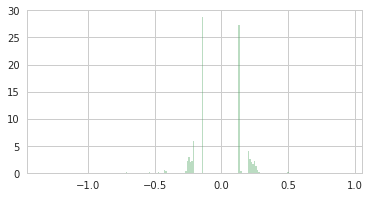

Epoch: 16. Loss: 1.472448706626892. Accuracy: 97.84
Means: [-0.6, -0.519, -0.437, -0.347, -0.266, -0.169, -0.071, 0.0, 0.071, 0.169, 0.269, 0.354, 0.428, 0.533, 0.596]
Mixing Proportions: [8.939, 8.955, 18.138, -2.307, -14.328, -3.196, 11.839, 8.099, 11.548, -3.026, -14.407, -1.968, 9.048, 8.57, 8.3]
Precisions: [9.198, 36.736, 44.379, 45.689, 24.449, -9.25, 26.825, 18.051, 36.659, 17.29, 27.58, -9.138, 29.948, 40.327, 43.432, 40.88]


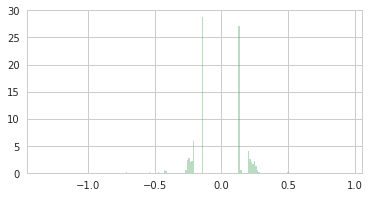

/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: range parameter must be finite.

In [267]:
#model = models.LeNet_300_100().cuda()
#print_dims(model)
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, 100)).cuda()
gmp = GaussianMixturePrior(16, [x for x in model.parameters()], 0.99)
sws_param2 = [gmp.rhos, gmp.gammas]
sws_param1 = [gmp.means]
ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_gmp = torch.optim.Adam(sws_param1, lr=1e-5)
optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)
graph_title='original_model/'

for epoch in range(30):
    model, loss = train_epoch_sws(model, optimizer, optimizer_gmp, optimizer_gmp2, criterion, train_loader)
    
    test_acc = test_accuracy(test_data_full, test_labels_full, model)
    train_acc = test_accuracy(train_data_full, train_labels_full, model)
    weight_penalty = get_weight_penalty(model)
    
    writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
    writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
    writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
    for name, param in model.named_parameters():
        writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (epoch%2==1):
        print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], test_acc[0]))
        print ( "Means: {}".format(list(np.around(gmp.means.data.clone().cpu().numpy(),3))) )
        print ( "Mixing Proportions: {}".format(list(np.around(gmp.rhos.data.clone().cpu().numpy(),3))) )
        print ( "Precisions: {}".format(list(np.around(gmp.gammas.data.clone().cpu().numpy(),3))) )
        show_all_weights(model)
    

#torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, training_epochs))

<Figure size 432x288 with 0 Axes>

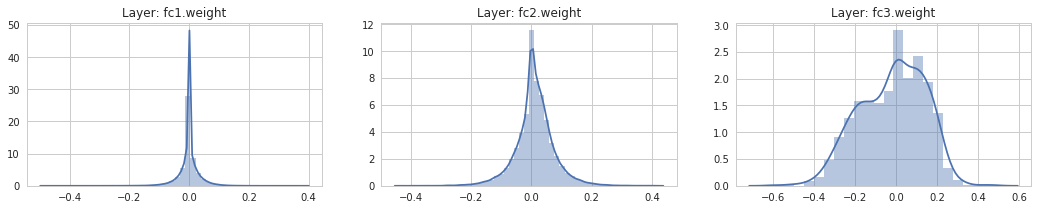

In [3]:
show_weights(model)

### 2. Re-train Model

**Temperature = 1**

Epoch: 20. Train CE Loss: 1.513, Train Accuracy: 99.037, Test CE Loss: 1.519, Test Accuracy: 97.990, Model L2: 18.815
Epoch: 40. Train CE Loss: 1.512, Train Accuracy: 99.055, Test CE Loss: 1.517, Test Accuracy: 98.040, Model L2: 18.733


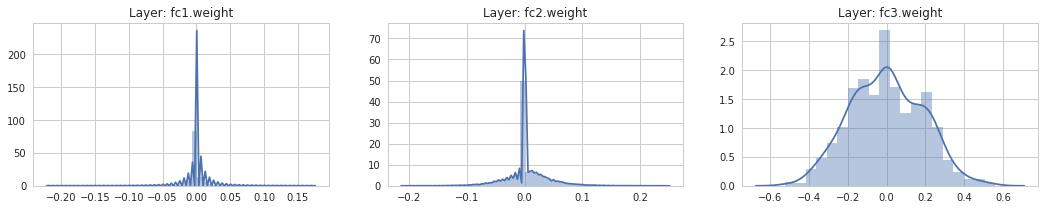

**Temperature = 5**

Epoch: 20. Train CE Loss: 1.516, Train Accuracy: 98.848, Test CE Loss: 1.522, Test Accuracy: 97.810, Model L2: 18.595
Epoch: 40. Train CE Loss: 1.514, Train Accuracy: 98.950, Test CE Loss: 1.520, Test Accuracy: 98.010, Model L2: 18.491


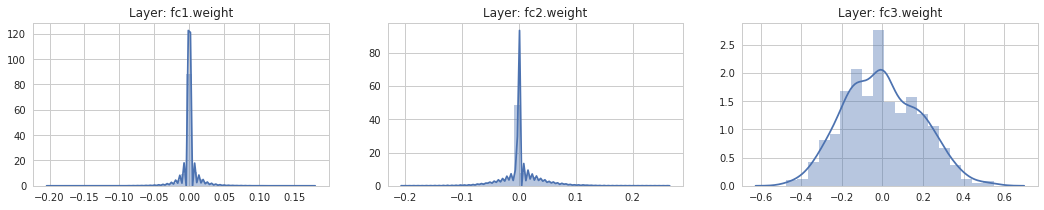

**Temperature = 10**

Epoch: 20. Train CE Loss: 1.531, Train Accuracy: 98.688, Test CE Loss: 1.534, Test Accuracy: 97.950, Model L2: 17.576
Epoch: 40. Train CE Loss: 1.529, Train Accuracy: 98.710, Test CE Loss: 1.532, Test Accuracy: 97.850, Model L2: 17.509


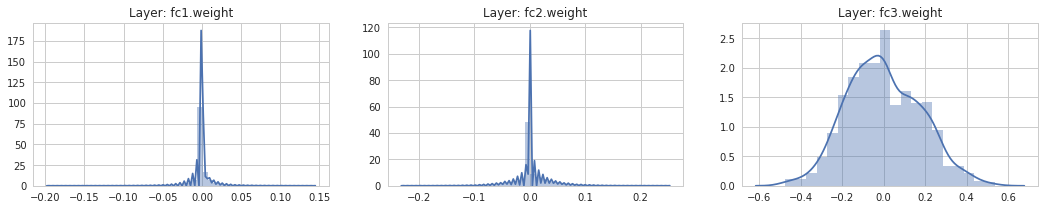

**Temperature = 15**

Epoch: 20. Train CE Loss: 1.576, Train Accuracy: 98.330, Test CE Loss: 1.575, Test Accuracy: 97.680, Model L2: 16.114
Epoch: 40. Train CE Loss: 1.575, Train Accuracy: 98.407, Test CE Loss: 1.575, Test Accuracy: 97.670, Model L2: 16.017


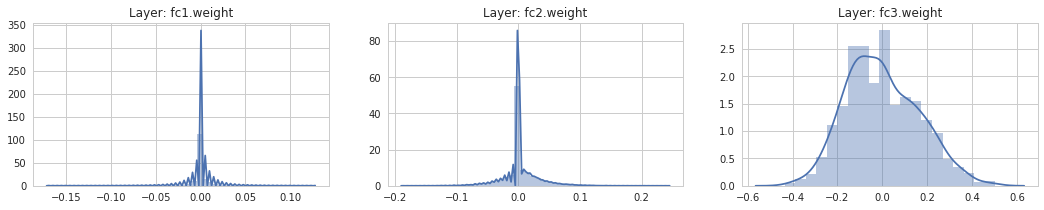

**Temperature = 20**

Epoch: 20. Train CE Loss: 1.648, Train Accuracy: 97.995, Test CE Loss: 1.645, Test Accuracy: 97.490, Model L2: 14.677
Epoch: 40. Train CE Loss: 1.648, Train Accuracy: 98.038, Test CE Loss: 1.644, Test Accuracy: 97.480, Model L2: 14.611


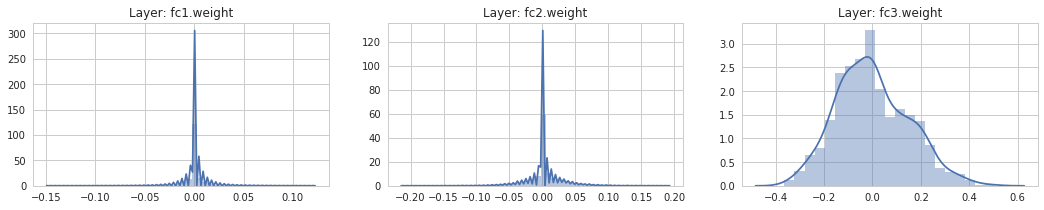

**Temperature = 25**

Epoch: 20. Train CE Loss: 1.729, Train Accuracy: 97.690, Test CE Loss: 1.724, Test Accuracy: 97.310, Model L2: 13.517
Epoch: 40. Train CE Loss: 1.727, Train Accuracy: 97.895, Test CE Loss: 1.722, Test Accuracy: 97.500, Model L2: 13.511


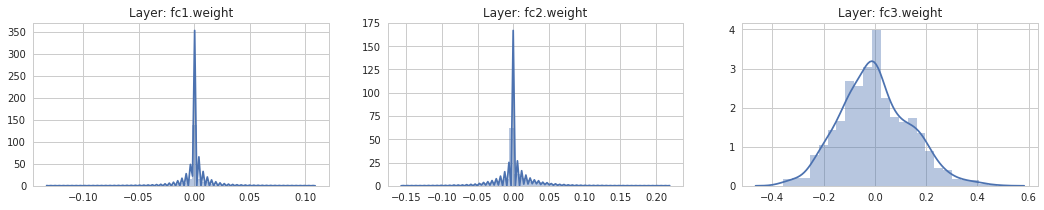

**Temperature = 30**

Epoch: 20. Train CE Loss: 1.806, Train Accuracy: 97.617, Test CE Loss: 1.800, Test Accuracy: 97.280, Model L2: 12.557
Epoch: 40. Train CE Loss: 1.806, Train Accuracy: 97.635, Test CE Loss: 1.801, Test Accuracy: 97.220, Model L2: 12.561


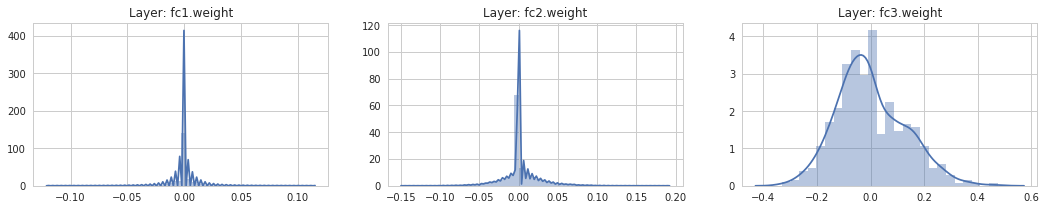

In [3]:
#Get KD Targets   
for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
    kd_outputs = model.kd_targets(train_data_full,T=temp)
    kd_dataset = torch.utils.data.TensorDataset(train_data_full.data, kd_outputs.data)#.data turns variable -> tensor
    train_kd_loader = torch.utils.data.DataLoader(dataset=kd_dataset, batch_size=batch_size, shuffle=True)

    #Load model
    model_kd = models.LeNet_300_100().cuda()
    model_kd.load_state_dict(model.state_dict())

    #Set up Optimisers and loss
    criterion_kd = nn.MSELoss()
    learning_rate_kd = 0.0005
    wd_kd = 0.0001
    optimizer_kd_1 = torch.optim.Adam(model_kd.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_2 = torch.optim.Adam(model_kd.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_3 = torch.optim.Adam(model_kd.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

    graph_title = "compressed_model_T_{}/".format(temp)

    for epoch in range(retraining_epochs):
        model_kd, loss = train_epoch(model_kd, optimizer_kd_3, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_2, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_1, criterion_kd, train_kd_loader)
        test_acc = test_accuracy(test_data_full, test_labels_full, model_kd)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_kd)
        weight_penalty = get_weight_penalty(model_kd)

        writer.add_scalars(graph_title + 'train_CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'train_Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'train_L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
        if (epoch%20==19):
            print('Epoch: {}. Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}'.format(epoch+1, train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty))
    torch.save(model_kd, model_dir + 'mnist_{}_kd_t{}_e{}.m'.format(model_kd.name, temp, retraining_epochs))
    show_weights(model_kd)

### 3. Prune Model

**Temperature = 1**

Train CE Loss: 1.862, Train Accuracy: 89.627, Test CE Loss: 1.857, Test Accuracy: 88.930, Model L2: 16.345, Parameters Pruned: 235301/266610 - 88.257%
Train CE Loss: 1.929, Train Accuracy: 85.725, Test CE Loss: 1.924, Test Accuracy: 84.600, Model L2: 16.124, Parameters Pruned: 226270/266610 - 84.869%


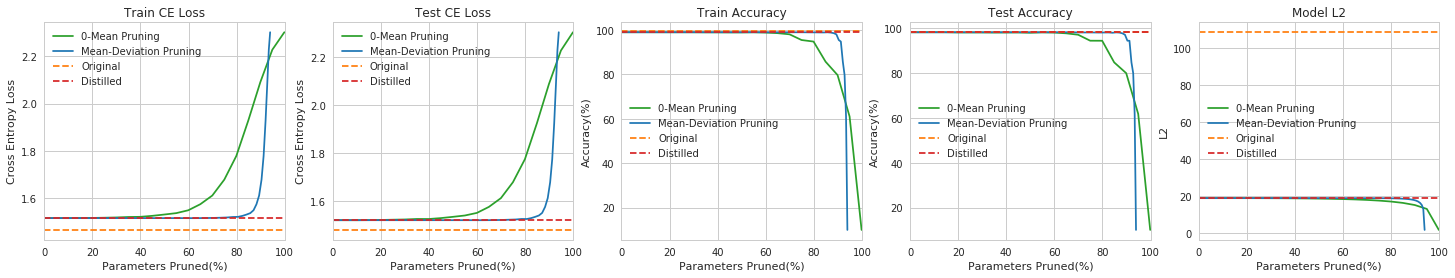

**Temperature = 5**

Train CE Loss: 1.848, Train Accuracy: 84.250, Test CE Loss: 1.844, Test Accuracy: 83.450, Model L2: 16.239, Parameters Pruned: 235622/266610 - 88.377%
Train CE Loss: 1.897, Train Accuracy: 82.622, Test CE Loss: 1.894, Test Accuracy: 81.950, Model L2: 15.949, Parameters Pruned: 226270/266610 - 84.869%


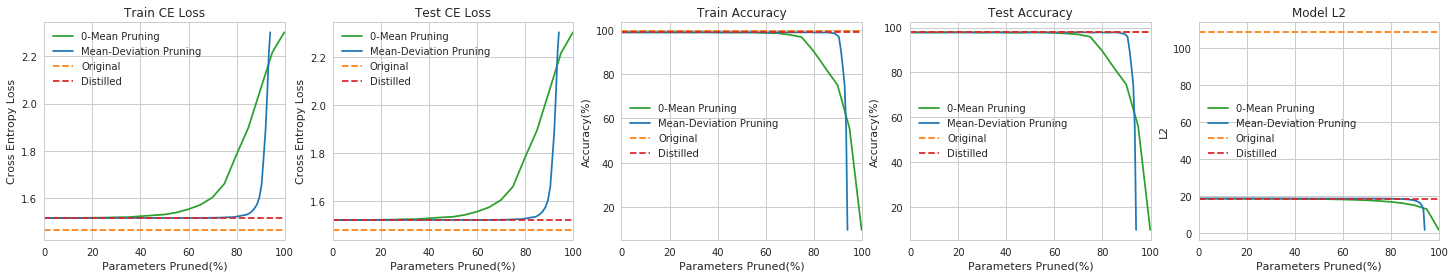

**Temperature = 10**

Train CE Loss: 1.869, Train Accuracy: 90.467, Test CE Loss: 1.861, Test Accuracy: 89.800, Model L2: 15.362, Parameters Pruned: 235608/266610 - 88.372%
Train CE Loss: 1.926, Train Accuracy: 92.660, Test CE Loss: 1.919, Test Accuracy: 91.990, Model L2: 15.180, Parameters Pruned: 226270/266610 - 84.869%


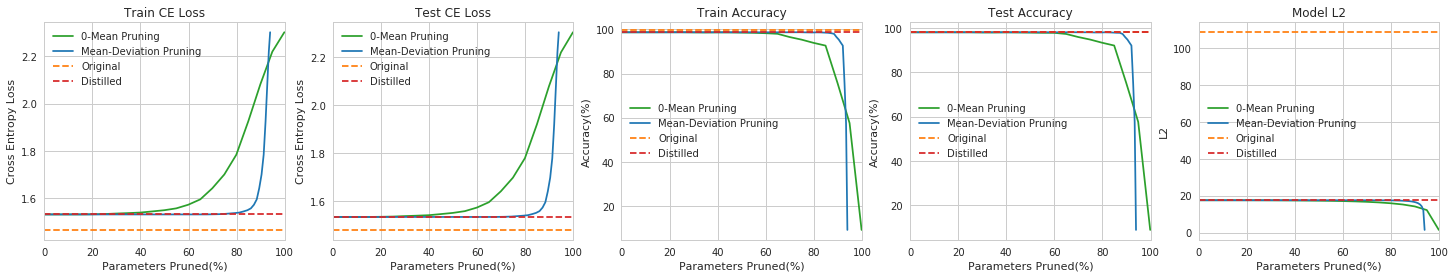

**Temperature = 15**

Train CE Loss: 1.928, Train Accuracy: 90.552, Test CE Loss: 1.922, Test Accuracy: 90.050, Model L2: 14.014, Parameters Pruned: 236170/266610 - 88.583%
Train CE Loss: 1.983, Train Accuracy: 84.900, Test CE Loss: 1.978, Test Accuracy: 84.110, Model L2: 13.849, Parameters Pruned: 226270/266610 - 84.869%


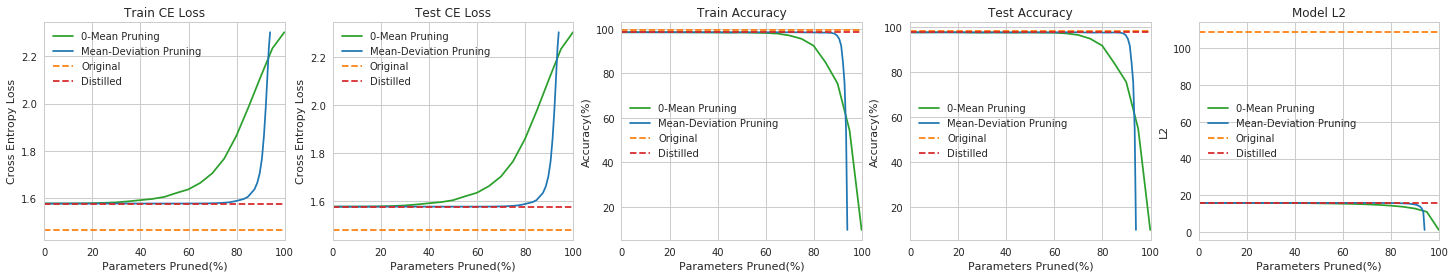

**Temperature = 20**

Train CE Loss: 1.981, Train Accuracy: 88.742, Test CE Loss: 1.975, Test Accuracy: 88.460, Model L2: 12.907, Parameters Pruned: 235772/266610 - 88.433%
Train CE Loss: 2.024, Train Accuracy: 87.882, Test CE Loss: 2.019, Test Accuracy: 87.350, Model L2: 12.730, Parameters Pruned: 226270/266610 - 84.869%


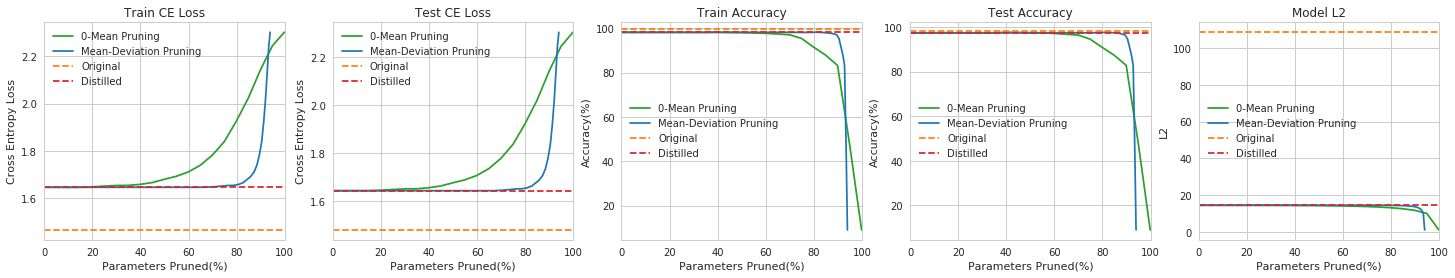

**Temperature = 25**

Train CE Loss: 2.031, Train Accuracy: 86.620, Test CE Loss: 2.025, Test Accuracy: 86.660, Model L2: 11.936, Parameters Pruned: 234994/266610 - 88.141%
Train CE Loss: 2.072, Train Accuracy: 83.885, Test CE Loss: 2.066, Test Accuracy: 83.910, Model L2: 11.764, Parameters Pruned: 226270/266610 - 84.869%


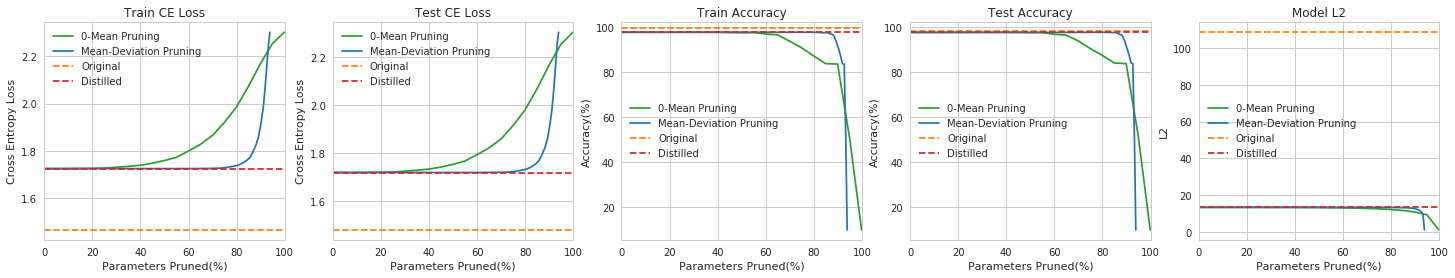

**Temperature = 30**

Train CE Loss: 2.100, Train Accuracy: 94.078, Test CE Loss: 2.096, Test Accuracy: 93.550, Model L2: 11.047, Parameters Pruned: 234621/266610 - 88.002%
Train CE Loss: 2.117, Train Accuracy: 88.603, Test CE Loss: 2.114, Test Accuracy: 88.120, Model L2: 10.959, Parameters Pruned: 226270/266610 - 84.869%


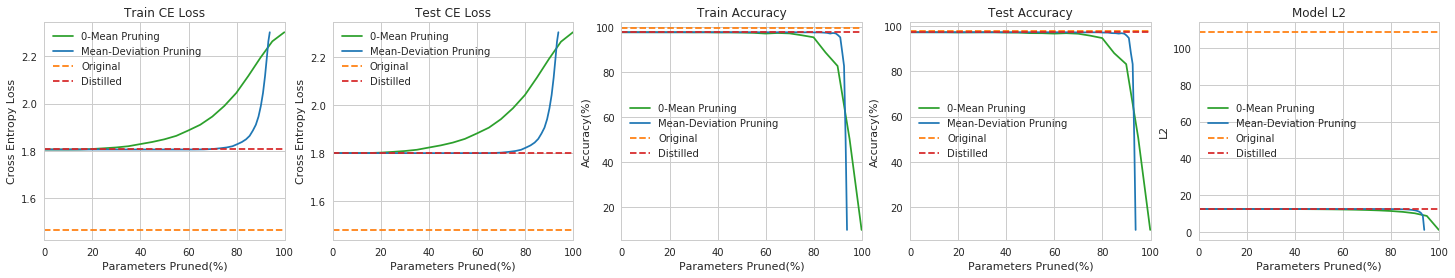

In [4]:
#Original Model
model = torch.load(model_dir + 'mnist_LeNet_300_100_100.m').cuda()
test_acc_o = test_accuracy(test_data_full, test_labels_full, model)
train_acc_o = test_accuracy(train_data_full, train_labels_full, model)
weight_penalty_o = get_weight_penalty(model)
compress_res = {}

for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    graph_title = "compressed_model_T_{}/".format(temp)
    #Retrained Model
    model_kd = torch.load(model_dir + 'mnist_LeNet_300_100_kd_t{}_e50.m'.format(temp)).cuda()
    test_acc_kd = test_accuracy(test_data_full, test_labels_full, model_kd)
    train_acc_kd = test_accuracy(train_data_full, train_labels_full, model_kd)
    weight_penalty_kd = get_weight_penalty(model_kd)
    
    #writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 0)
    #writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 100)
    #writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 0)
    #writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 100)
    #writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 0)
    #writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 100)
    
    model_c = models.LeNet_300_100().cuda()
    pruner = model_prune(model_kd.state_dict())
    deviation_list = [x/10.0 for x in range(0,21)]
    percentile_list = range(0,101,5)
    
    
    dev_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []}
    for i,lim in enumerate(deviation_list):
        model_c.load_state_dict(pruner.deviation_prune(lim))
        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)

        dev_res['train ce'].append(train_acc[1])
        dev_res['test ce'].append(test_acc[1])
        dev_res['train acc'].append(train_acc[0])
        dev_res['test acc'].append(test_acc[0])
        dev_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        dev_res['L2'].append(weight_penalty)

        writer.add_scalars(graph_title + 'prune_CrossEntropyLoss', {'Deviation Test': test_acc[1], 'Deviation Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_Accuracy', {'Deviation Test': test_acc[0], 'Deviation Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_L2', {'Deviation': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)

        if(i==13):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
    
    perc_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : [],} 
    for i,lim in enumerate(percentile_list):
        model_c.load_state_dict(pruner.percentile_prune(lim))

        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)
        perc_res['train ce'].append(train_acc[1])
        perc_res['test ce'].append(test_acc[1])
        perc_res['train acc'].append(train_acc[0])
        perc_res['test acc'].append(test_acc[0])
        perc_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        perc_res['L2'].append(weight_penalty)

        writer.add_scalars(graph_title + 'prune_CrossEntropyLoss', {'Percentile Test': test_acc[1], 'Percentile Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_Accuracy', {'Percentile Test': test_acc[0], 'Percentile Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_L2', {'Percentile': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)
        
        if(i==17):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
            
    prune_plot(temp, dev_res, perc_res, test_acc_o, train_acc_o, weight_penalty_o, test_acc_kd, train_acc_kd, weight_penalty_kd)
    #t_res={} 
    #t_res['dev']=dev_res
    #t_res['perc']=perc_res
    #compress_res[temp]=t_res